<a href="https://colab.research.google.com/github/YatipaC/Tokenization/blob/main/Trade_Volumes_Tokenization_Metaheuristic_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install cvxpy
!pip install mealpy==2.0.0 
# !pip install --upgrade mealpy # note: mealpy-2.4.0 cannot run this code.

     |████████████████████████████████| 370 kB 5.2 MB/s 
     |████████████████████████████████| 7.4 MB 29.7 MB/s 


#### Data: https://drive.google.com/file/d/1-U02XPIJVutZ2ROy88up3S4dDHn4c4Uz/view?usp=sharing 

In [2]:
# data currency pair
! gdown --id 1I7Ygb8OP015IC0yfjSHOpx6FkNpNyU5r # EURUSD
! gdown --id 1NnRijN86VAnJpFD7JgaQzl9MuDaOmDWF # GBPUSD
! gdown --id 1YsAtnwIgf4WbP1PzqEoPlm3WxiQ4XXHn # AUDUSD
! gdown --id 1cPHT9fEI-AUVUMKYPVaJpn3gvf3FtkTF # NZDUSD

Downloading...
From: https://drive.google.com/uc?id=1I7Ygb8OP015IC0yfjSHOpx6FkNpNyU5r
To: /content/EURUSD1440.csv
100% 253k/253k [00:00<00:00, 64.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NnRijN86VAnJpFD7JgaQzl9MuDaOmDWF
To: /content/GBPUSD1440.csv
100% 255k/255k [00:00<00:00, 98.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YsAtnwIgf4WbP1PzqEoPlm3WxiQ4XXHn
To: /content/AUDUSD1440.csv
100% 253k/253k [00:00<00:00, 97.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cPHT9fEI-AUVUMKYPVaJpn3gvf3FtkTF
To: /content/NZDUSD1440.csv
100% 251k/251k [00:00<00:00, 90.5MB/s]


In [3]:
# Maker data
! gdown --id 17S2FzayRZBfSiUWAPVlXMe6eSM8wcxEQ # credit_2
! gdown --id 11Xww60VqvKNkqeobzzPBV8KxmVLgXvRX # finished_credits
! gdown --id 1-U02XPIJVutZ2ROy88up3S4dDHn4c4Uz # market_vat_call 


Downloading...
From: https://drive.google.com/uc?id=17S2FzayRZBfSiUWAPVlXMe6eSM8wcxEQ
To: /content/credits_2.csv
100% 480k/480k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=11Xww60VqvKNkqeobzzPBV8KxmVLgXvRX
To: /content/finished_credits.csv
100% 1.75M/1.75M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-U02XPIJVutZ2ROy88up3S4dDHn4c4Uz
To: /content/maker_vat_calls_processed_2019-2021.csv
100% 95.1M/95.1M [00:00<00:00, 176MB/s]


In [4]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import math
from datetime import date, timedelta
from numpy import sqrt,mean,log,diff
from matplotlib import pyplot as plt
import unittest
import seaborn as sns
import heapq
from sympy import symbols, solve, Eq
import json 
import unittest
import cvxpy as cp
import scipy.sparse as sp

from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy import linalg as LA

In [5]:
# Open Forex data file
def open_file(qq):
    data_list = []
    name = str(qq) + '.csv'
    with open(name, 'r') as reading:
        file_input = reading.read().split('\n')

    for row in file_input:
        data_list.append(row.split('\t'))
    data = pd.DataFrame(data_list,columns=['date', 'open', 'high', 'low', 'close', 'vol'])
    data['close'] = pd.to_numeric(data['close'],errors = 'coerce')
    data['vol'] = pd.to_numeric(data['vol'],errors = 'coerce')
    return data

# Exchange rate and volume of Forex data 
def get_rate_and_volume(data_file_name, V, start_date, end_date):
    exchange_rate = list()
    volume = list()
    for i, single_date in enumerate(daterange(start_date, end_date)):
        a_date = single_date.isoformat()+str(' 00:00')
        if a_date not in open_file(data_file_name)['date'].values:
            a_date = (single_date-timedelta(days=1)).isoformat()+str(' 00:00')
        print(a_date)
        exchange_rate.append(float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['close'].values))
        exchange_rate.append(V * float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['vol']))
    return exchange_rate, volume

In [6]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 31)
pairs = ['EURUSD', 'AUDUSD', 'GBPUSD', 'NZDUSD']
V = 100

In [7]:
exchange_rates_array = list()
volumes_array = list()
dates_array = list()
foreign_risk_free_rate = list()
domestic_risk_free_rate = list()

# total Forex volume and exchange rate 
for pair_index in range(len(pairs)):
    data_file_name = pairs[pair_index] + '1440'
    data = open_file(data_file_name)
    dates = data['date'].values
    dates = [x[:-6] for x in dates]
    exchange_rates = data['close'].values
    volumes = data['vol'].values
    start_index = [i for i in range(len(dates)) if dates[i] == str(start_date)][0]
    end_index = [i for i in range(len(dates)) if dates[i] == str(end_date)][0]
    dates_array.append(dates[start_index:end_index+1])
    exchange_rates_array.append(exchange_rates[start_index:end_index+1])
    volumes_array.append(volumes[start_index:end_index+1])

exchange_rates_array = np.array(exchange_rates_array)
volumes_array = np.array(volumes_array)

In [8]:
print(np.shape(exchange_rates_array))
print(np.cov(exchange_rates_array))
print(np.corrcoef(exchange_rates_array))

(4, 314)
[[0.00198052 0.0016558  0.00133738 0.0012721 ]
 [0.0016558  0.00169787 0.00137727 0.00130886]
 [0.00133738 0.00137727 0.00163975 0.00118338]
 [0.0012721  0.00130886 0.00118338 0.00109828]]
[[1.         0.90295525 0.74212144 0.86252955]
 [0.90295525 1.         0.8254235  0.95848165]
 [0.74212144 0.8254235  1.         0.88181901]
 [0.86252955 0.95848165 0.88181901 1.        ]]


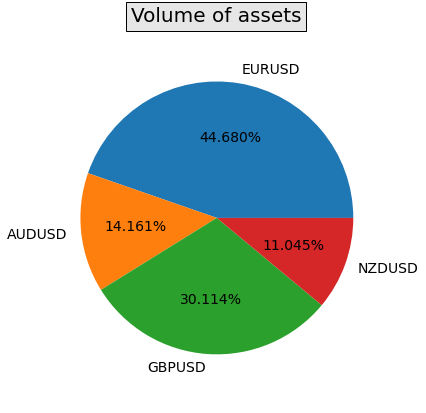

In [9]:
# Total trading volume 
fig = plt.figure(figsize=(6,6))
plt.pie(np.sum(volumes_array, axis=1), labels=pairs,autopct='%1.3f%%', radius = 2, textprops={'fontsize': 14})
plt.title("Volume of assets", bbox={'facecolor':'0.9', 'pad':5}, fontsize = 20)
plt.axis('equal')
plt.tight_layout()
plt.show()

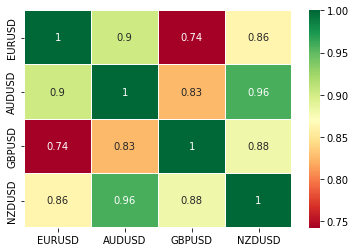

In [10]:
# Correlation between different currency pair
exchange_rates_pd = pd.DataFrame(exchange_rates_array.transpose(), columns = pairs)

ax = sns.heatmap(exchange_rates_pd.corr(), cmap='RdYlGn', linewidths=.1,annot=True)
# plt.title("Heatmap of closing price", fontsize = 20)
plt.savefig("heatmap.pdf")
plt.show()

The assumption of dataset is that each currency pair isn't correlating with each other while there is almost one correlation factor except diagonal. To sum up, this correlation matrix shows that we have the wrong model assumptions.

In [11]:
exchange_rates_pd.corr(method='pearson')

,EURUSD,AUDUSD,GBPUSD,NZDUSD
EURUSD,1.000000,0.902955,0.742121,0.862530
AUDUSD,0.902955,1.000000,0.825423,0.958482
GBPUSD,0.742121,0.825423,1.000000,0.881819
NZDUSD,0.862530,0.958482,0.881819,1.000000


In [12]:
# https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa
print(f'skew\nMax:{exchange_rates_pd.skew(axis = 0, skipna = True).max()},\nMin:{exchange_rates_pd.skew(axis = 0, skipna = True).min()}')
exchange_rates_pd.skew(axis = 0, skipna = True)

skew
Max:0.13036180841990816,
Min:-0.5467841810520316


EURUSD    0.130362
AUDUSD   -0.543672
GBPUSD   -0.546784
NZDUSD   -0.233496
dtype: float64

In [13]:
print(f'kurtosis\nMax:{exchange_rates_pd.kurtosis(axis = 0, skipna = True).max()},\nMin:{exchange_rates_pd.kurtosis(axis = 0, skipna = True).min()}')
exchange_rates_pd.kurtosis(axis = 0, skipna = True)

kurtosis
Max:0.1069398087094311,
Min:-1.3389935828426816


EURUSD   -1.338994
AUDUSD   -0.171022
GBPUSD    0.106940
NZDUSD   -0.281357
dtype: float64

**Skewness**

It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.
It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.
- Negative skew mean that the exchange rate was higher than the average value.
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.


**Kurtosis**

Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually *the measure of outliers present in the distribution*.
- High kurtosis in a data set is an indicator that data has heavy tails or outliers.
- Platykurtic: (Kurtosis < 3): Distribution is shorter, tails are thinner than the normal distribution. The peak is lower and broader than Mesokurtic, which means that data are light-tailed or lack of outliers.
The reason for this is because the extreme values are less than that of the normal distribution.

In [94]:
# daily standard deviation of returns
currecy_pair = ['EURUSD','AUDUSD', 'GBPUSD','NZDUSD']
for i in range(4):
  col_name = "log return" + str(currecy_pair[i])
  exchange_rates_pd[col_name] = np.log(exchange_rates_pd[currecy_pair[i]]/exchange_rates_pd[currecy_pair[i]].shift())
  volati = exchange_rates_pd[col_name].std()
  print(f'daily volatile of {currecy_pair[i]} = {volati}')


daily volatile of EURUSD = 0.004292628181084004
daily volatile of AUDUSD = 0.007258954442465539
daily volatile of GBPUSD = 0.006407473269937323
daily volatile of NZDUSD = 0.006825346185043379


In [101]:
for i in range(4):
  # calculate daily logarithmic return 
  a = (np.log(exchange_rates_pd[currecy_pair[i]] /
      exchange_rates_pd[currecy_pair[i]].shift(-1)))
  # calculate daily standard deviation of returns
  daily_std = np.std(a)
  # annualized daily standard deviation
  std = daily_std * 252 ** 0.5
  print(std)
  # print(f'annualized daily volatile of {currecy_pair[i]} = {std}')

0.06803441753648008
0.1150481049332987
0.1015528700393212
0.10817579175166298


**Volatile** 
*ref* https://www.quora.com/How-do-I-calculate-a-rolling-measure-of-volatility-of-time-series-price-data-in-a-Pandas-Dataframe



## Discrete tokenization

In [14]:
class Discrete:
    def __init__(self, A0, N0, k0):
        self.A = A0.astype(int) # array of assets
        self.N = N0 # number of assets types
        self.k = k0 # number of assets in each package


    def preprocess(self):
        assert self.N == len(self.A), "Wrong N"  
        assert self.k <= len(self.A), "Wrong k" 
        self.A = self.A * self.k
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes] 
        a = np.sort(self.A, axis=None) # min-max sorting
        largest_ele_index = heapq.nlargest(self.k-1, range(len(a)))
        S = 0
        for i in range(0, len(a)):
            if i not in largest_ele_index:
                S = S + np.sum(a[i]) # sum of all token except biggest k-1 types
        B = 0
        n = 2
        a_res = a
        for start in range(self.N - self.k+1,self.N): # a_{N-k+n} = min[A_{N-k+n}, S/(n-1)] to remove some tokens
            index_S_inner = self.N-self.k+n-1
            S_inner = np.sum(a[0:index_S_inner])
            if math.floor(S_inner/(n-1)) >= A[self.N-self.k+n-1]:
                a_res[self.N-self.k+n-1] = A[self.N-self.k+n-1]
                S = S + a_res[index_S_inner]
            else:
                a_res[self.N-self.k+n-1] = math.floor(S_inner/(n-1))
                S = S + a_res[index_S_inner]
            assert a_res[self.N-self.k+n-1] == min(A[self.N-self.k+n-1],math.floor(S_inner/(n-1)))
            delta = A[index_S_inner] - a_res[index_S_inner] 
            B = B + delta # total number of tokens put off from packages
            n = n+1            
        return a_res, B


    def distribution(self, a_res, B, return_distribution_matrix=False):
        S = np.sum(a_res)
        M = math.floor(S/self.k)
        B0 = abs(S - M*self.k) # number of token that isn't falling into packages due to multiplicity of S
        n = self.N - B0 +1
        for n in range(n, self.N+1):
            a_res[n-1] = a_res[n-1] - 1 # remove 1 tokens from last token's types
            B = B + B0
        l_n = np.zeros(self.N+1)
        r_n = np.zeros(self.N+1)
        for n in range(1,self.N+1):
            l_n[n] = np.sum(a_res[0:n-1])+1
            r_n[n] = np.sum(a_res[0:n])
        if return_distribution_matrix: # unique composition of each package as much as possible 
            C_M = np.zeros((self.k, M))
            n = 1
            for i in range(1, M + 1):
                for j in range(1, self.k+1):
                    check_index = i + M * (j - 1)
                    for n in range(1, self.N+1):
                        if check_index <= r_n[n] and check_index >= l_n[n]:
                            C_M[j-1, i-1] = self.inverse_sort_indexes[n-1] + 1
                        n =n+1
            return a_res[self.inverse_sort_indexes]/self.k, M, C_M
        else:
            return a_res[self.inverse_sort_indexes]/self.k, M

In [15]:
class Discrete_Test(unittest.TestCase):
    def setUp(self):
        self.A_t = np.array([3, 4, 3, 5, 7, 2])
        self.k_t = 4
        self.res = Discrete(self.A_t, len(self.A_t), self.k_t)
    
    def test_preprocess(self):
        a_preprocess, B =  self.res.preprocess()
        np.array_equal(a_preprocess, [8, 12, 12, 16, 20, 22])
        self.assertEqual(B, 6)
    
    def test_distribution(self):
        a_preprocess, B = self.res.preprocess()
        a_dis, M, C_M = self.res.distribution(a_preprocess, B, return_distribution_matrix=True)
        self.assertTrue(np.allclose(a_dis, [3, 4, 3, 4.75, 5.25, 2]))
        self.assertEqual(M, 22)
        actual_C_M = [[2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,],
                     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,],
                     [5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,],
                     [6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,]]
        np.array_equal(C_M, actual_C_M)

unittest.main(argv=[''], verbosity=2, exit=False)

test_distribution (__main__.Discrete_Test) ... ok
test_preprocess (__main__.Discrete_Test) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.017s

OK


In [16]:
# test example

A = np.array([3, 4, 3, 5, 7, 2])
N = len(A)
k = 4
res_discrete = Discrete(A, N, k)
res_1, B = res_discrete.preprocess()
a_res, M, my_matrix = res_discrete.distribution(res_1, B, return_distribution_matrix=True)
print('A:', A)
print('a:', a_res)
print(f'C_M: \n', my_matrix)

A: [3 4 3 5 7 2]
a: [3.   4.   3.   4.75 5.25 2.  ]
C_M: 
 [[2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


## MARKED

In [17]:
# Test volume of Forex data as input

np.floor(volumes_array[:, 0])
k = 3
A = np.floor(volumes_array[:, 0]).astype(int)
N = len(A)
res_discrete = Discrete(A, N, k)
res_1, B = res_discrete.preprocess()
a_res, _ = res_discrete.distribution(res_1, B)
print("A: ", volumes_array[:, 0])
print("a: ", a_res.astype(float))

A:  [ 2631  3364 13079  3966]
a:  [2631. 3364. 4980. 3966.]


In [18]:
# Tokenized volume by using discrete tokenization algorithm

k = 3
N = len(pairs)

tokenized_volume = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = np.floor(volumes_array[:, trading_day_index]).astype(int) 
    res_discrete = Discrete(A, N, k)
    res_1, B = res_discrete.preprocess()
    a_res, _ = res_discrete.distribution(res_1, B)
    # print(f"A = {A}\nres_1 = {a_res}\nfactoring = {np.divide(a_res, A)}")
    tokenized_volume[trading_day_index] = np.sum(a_res) # (314,)

array([487247,  73627, 236689,  81005])

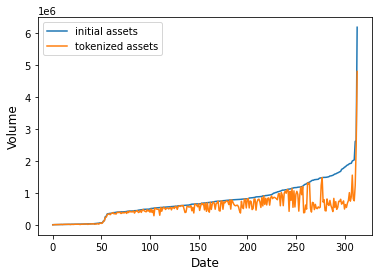

In [20]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(np.sum(volumes_array, axis=0)[sort_indexes],label = "initial assets")
plt.plot(tokenized_volume[sort_indexes], label = "tokenized assets")
# plt.title("Daily trading volume (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.legend()
plt.savefig("discreteTokenization.pdf")
plt.show()

Tokenized fraction:  0.7061052803816608


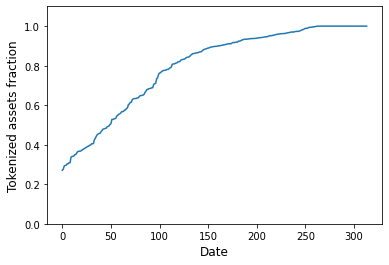

In [21]:
data_to_plot_discrete = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]

plt.plot(np.sort(data_to_plot_discrete))
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [22]:
covariances = np.cov(exchange_rates_array)
allowed_package_covariance = np.zeros((len(pairs),))
for index in range(len(pairs)):
    vector = np.ones((len(pairs),)) / k
    vector[index] = 0
    current_covariance = np.matmul(np.matmul(vector, covariances), vector)
    allowed_package_covariance[index] = current_covariance
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(allowed_package_covariance))
print("(Minium) Reduction factor vs k: ", (np.max(covariances) / np.max(allowed_package_covariance)), ' vs ', k)

Max covariance:  0.001980523976794327
Max package variance:  0.0015621152653092349
(Minium) Reduction factor vs k:  1.2678475275012848  vs  3


The total number of tokenized tokens is a_star. The tokenized faction below than one means that some assets in A haven't been tokenized due to the multiplicity of a total number of S tokens in the size of packages k. Therfore, around 70.61% of dataset has been tokenized. In addition, the variance reduction factor is just 1.26 or 26% less, not equal to 3 times less due to the wrong model assumption

## Continuous tokenization

In [23]:
import numpy as np
from sympy import symbols, solve, Eq
class Continuous:
    def __init__(self, N0, A0, var_reduc):
        self.A = A0
        self.N = N0
        self.var = var_reduc 

    def search(self):
        N = self.N
        assert self.N == len(self.A), "Wrong N" 
        var = self.var
        E = np.array([0],dtype='float64') # expectation of taken assets
        V = np.array([0],dtype='float64') # varaince of taken assets
        a = np.zeros(self.N)
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        A = np.insert(A, 0, 0)
        for n in range(0, N): # replace a_k from A_n with A_{n+1}
            E_new = E + (N-n)*(A[n+1] - A[n])
            V_new = V + (N-n)*(A[n+1]**2 - A[n]**2)
            if (1/var)*(E_new)**2 >= V_new:
                E = E_new
                V = V_new
                for k in range(n, N):
                    a[k] = A[n+1]
            else:
                x = symbols('x')
                eq = (1/var)*(E + (N - n)*(x - A[n]))**2 - V - (N - n) * (x**2 - A[n]**2)
                A_sol = solve(eq)
                assert A_sol != [{x: 0.0}], "Root equals to zero" 
                A_sol =  min(list(A_sol[1].values())[0], A[n + 1])
                E = E + (N-n)*(A_sol - A[n])
                V = V + (N-n)*(A_sol**2 - A[n]**2)
                n_star = n + 1
                for k in range(n_star-1, N):
                    a[k] = A_sol
        return a[self.inverse_sort_indexes]

    def construct_pack(self, a):
        M = np.linalg.norm((a), ord=1) # number of packages
        C_M  = a/M # composition of each M packages
        return  a[self.inverse_sort_indexes], M, C_M

In [24]:
class Continuous_Test(unittest.TestCase):
    def setUp(self):
        self.A_t = np.array([50, 8, 100, 3])
        self.res =  Continuous(len(self.A_t), self.A_t, 3)
    
    def test_search(self):
        a_search =  self.res.search()
        self.assertTrue(np.allclose(a_search, [19.48528137, 8, 50, 3]))
    
    def test_construct_pack(self):
        a_search = self.res.search()
        a_cons, M, C_M = self.res.construct_pack(a_search)
        self.assertTrue(np.allclose(a_cons,[50, 8, 3, 19.48528137]))
        self.assertTrue(np.allclose(C_M, [0.24209745, 0.09939706, 0.6212316, 0.0372739 ]))
        self.assertAlmostEqual(M, 80.48528137423853)

unittest.main(argv=[''], verbosity=2, exit=False)

test_construct_pack (__main__.Continuous_Test) ... ok
test_search (__main__.Continuous_Test) ... ok
test_distribution (__main__.Discrete_Test) ... ok
test_preprocess (__main__.Discrete_Test) ... ok

----------------------------------------------------------------------
Ran 4 tests in 1.196s

OK


In [25]:
# test example
A = np.array([3,2,7,4,9]) 
N = len(A)

my_var = np.var(A)
length = len(A)
my_min = np.min(A)
my_max = np.max(A)
rand1 = np.random.randint(my_min, my_max + 1, size=length)
rand2 = np.random.randint(my_min, my_max + 1, size=length)
cov_rand = np.cov(rand1, rand2)[0, 0]
var_red = cov_rand/my_var

res_conti = Continuous(N, A, var_red)
res_1 = res_conti.search()
print("final a_n = ", res_1)
a, _, C_M = res_conti.construct_pack(res_1)
print("composition is", C_M)

final a_n =  [3. 2. 7. 4. 9.]
composition is [0.12 0.08 0.28 0.16 0.36]


In [26]:
# test example

k = 3

A = np.array([1000, 1, 1, 1])
res_conti = Continuous(len(A), A, k)
print
res_1 = res_conti.search()
a, _, C_M = res_conti.construct_pack(res_1)
print("final a_n = ", res_1)
print("composition is", C_M)

final a_n =  [3. 1. 1. 1.]
composition is [0.5        0.16666667 0.16666667 0.16666667]


## MARKED

In [27]:
# Tokenized volume by using continuous tokenization algorithm

k = 3
N = len(pairs)
a_star_conti = []
tokenized_volume = np.zeros((volumes_array.shape[1],))
package_variance = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = volumes_array[:, trading_day_index] 
    res_conti = Continuous(N, A, k)
    res_1 = res_conti.search()  
    a, _, C_M = res_conti.construct_pack(res_1)
    tokenized_volume[trading_day_index] = np.sum(res_1) 
    
    package_variance[trading_day_index] = np.matmul(np.matmul(C_M, covariances), C_M) #(314,)
    a_star_conti.append(a) # len = 314 

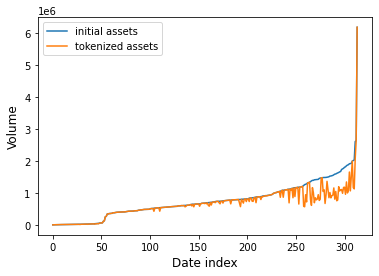

In [28]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(np.sum(volumes_array, axis=0)[sort_indexes],label = "initial assets")
plt.plot(tokenized_volume[sort_indexes], label = "tokenized assets")
plt.xlabel('Date index', fontsize=12)
plt.ylabel('Volume', fontsize=12)
# plt.title("Daily trading volume (continuous)", fontsize = 16)
plt.legend()
plt.savefig("continuousTokenization.pdf")
plt.show()

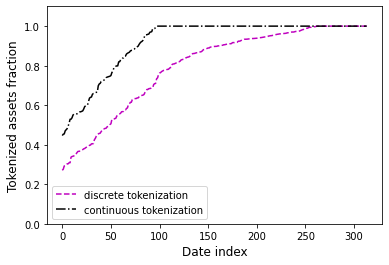

Tokenized fraction:  0.8623487679062549


In [29]:
data_to_plot_continuous = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]

plt.plot(np.sort(data_to_plot_discrete), '--m',label = "discrete tokenization")
plt.plot(np.sort(data_to_plot_continuous), '-.k',label = "continuous tokenization")
plt.ylim([0,1.1])
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.xlabel('Date index', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.legend()
plt.savefig("tokenizaedFractions.pdf")
plt.show()
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [30]:
covariances = np.cov(exchange_rates_array)
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(package_variance))
print("(Minimum) Reduction factor vs k: ", (np.max(covariances) / np.max(package_variance)), ' vs ', k)

Max covariance:  0.001980523976794327
Max package variance:  0.0016173814983811013
(Minimum) Reduction factor vs k:  1.2245249366192879  vs  3


The tokenized fraction of continuous tokenization is around 86.23% which is higher than discrete tokenization. Continuous tokenization is suitable for a large class of dataset because this tokenization could consider a wider class of tokenized matrix for tokenization, instead of an integer. In contrast, discrete tokenization is suitable for the smaller dataset. Moreover, the varaince reduction is not equal to 3 due to wrong model assumption.

## Information for blockchain

In [31]:
trading_day_index = 0
dict_for_blockchain = dict()
dict_for_blockchain['trading_day'] = dates_array[0][trading_day_index]

k = 3
A = volumes_array[:, trading_day_index]
res_conti = Continuous(len(A), A, k)
res_1 = res_conti.search()
a, _, C_M = res_conti.construct_pack(res_1)
dict_for_blockchain['initial assets'] = list([int(x) for x in A])
dict_for_blockchain['pairs'] = pairs
dict_for_blockchain['algorithm'] = 'continuous'
dict_for_blockchain['packages_number'] = round(sum(res_1))
dict_for_blockchain['package_content'] = list(C_M)


json_for_blockchain = json.dumps(dict_for_blockchain, indent = 4)  
print(json_for_blockchain)

{
    "trading_day": "2020-01-01",
    "initial assets": [
        2631,
        3364,
        13079,
        3966
    ],
    "pairs": [
        "EURUSD",
        "AUDUSD",
        "GBPUSD",
        "NZDUSD"
    ],
    "algorithm": "continuous",
    "packages_number": 19786,
    "package_content": [
        0.13297611027629772,
        0.1700234264422142,
        0.4965507280645376,
        0.2004497352169505
    ]
}


# Continuous with covariance matrix K

### Portfolio sold-out problem
The goal is to assemble as many good enough standard portfolio as possible
- The set of M packages: $C_{M}=\left(\vec{c}_{1}|\ldots| \vec{c}_{M}\right)$
where $\forall m=1, \ldots, M:\left\|\vec{C}_{m}\right\|_{1}=$ constant
- The problem: $M \rightarrow \max _{M, C_{M}}: C_{m}^{T} K \vec{C}_{m} \leq \sigma^{2}$

Under constraints: 
- $ \vec{c} T \vec{c} \leq \sigma^{2} \cdot\|\vec{c}\|_{1}^{2}$
- $\overrightarrow{0} \leq M \vec{c} \leq \vec{A}$
- $\|\vec{c}\|_{1}=1$

In [32]:
sigma2 = 0.00198/1.27 # 0.00198/1.2245
covariance_matrix = exchange_rates_pd.cov().values

In [33]:
def margine(vector_a, sigma2=sigma2, covariance_matrix=covariance_matrix):
    assets_number = len(vector_a)
    assert sigma2 > 0, "Required sigma2 > 0" 
    assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
    
    return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) # constraint 1

def margine_gradient(vector_a, sigma2=sigma2, covariance_matrix=covariance_matrix): # didn't use this function
    return 2 * sigma2 * np.linalg.norm((vector_a), ord=1) - 2 * np.matmul(covariance_matrix, vector_a)

In [34]:
from mealpy.bio_based import SMA
import numpy as np


def obj_function(solution):
    
    def violate(value):
        return 0 if value >= 0 else value

    fx = np.sum(solution)

## Increase the punishment for g1 and g4 to boost the algorithm (You can choice any constraint instead of g1 and g4)
    fx += violate(margine(solution)) / sigma2 #  (p)  violate by constraint 1 with sum of obj fn
  
    return fx


## Run the algorithm
A_size = 4
A = volumes_array[:, 0] # sample column
problem_dict1 = {
    "obj_func": obj_function,
    "lb": [0 for x in range(A_size)],
    "ub": list(A),
    "minmax": "max",
    "verbose": False,
} # (p) ub and lb is constraint 
model1 = SMA.BaseSMA(problem_dict1, epoch=100, pop_size=50, pr=0.03)
model1.solve()
print(margine(model1.solution[0]))
print(model1.solution[0])
print(A)

70133.11529587186
[ 2631.  3364. 13079.  3966.]
[ 2631  3364 13079  3966]


100%|██████████| 314/314 [10:33<00:00,  2.02s/it]


Tokenized fraction:  0.9103702609459403


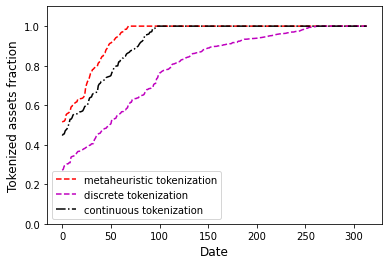

In [35]:
from tqdm import tqdm
np.random.seed(0) 

tokenized_volume_meta = np.zeros((volumes_array.shape[1],))
margines = list()
tokenizations = list()
d_candidates_size = 10
A_size = 4
for trading_day_index in tqdm(range(len(volumes_array[0]))):
    A = volumes_array[:, trading_day_index]
    problem_dict1 = {
        "obj_func": obj_function,
        "lb": [0 for x in range(A_size)],
        "ub": list(A),
        "minmax": "max",
        "verbose": False,
    }

    ## Run the algorithm
    model1 = SMA.BaseSMA(problem_dict1, epoch=100, pop_size=50, pr=0.03)
    model1.solve()
    tokenized_volume_meta[trading_day_index] = np.sum(model1.solution[0])
    margines.append(margine(model1.solution[0]))
    tokenizations.append(model1.solution[0])
    

data_to_plot_opti = [tokenized_volume_meta[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume_meta))]

plt.plot(np.sort(data_to_plot_opti), '--r',label = "metaheuristic tokenization")
plt.plot(np.sort(data_to_plot_discrete), '--m',label = "discrete tokenization")
plt.plot(np.sort(data_to_plot_continuous), '-.k',label = "continuous tokenization")
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
plt.legend()
print("Tokenized fraction: ", np.sum(tokenized_volume_meta) / np.sum(volumes_array))

In [36]:
print('The number of diversification condition violations:', np.sum([x < 0 for x in margines]))

The number of diversification condition violations: 0


In [37]:
tokenizations = np.array(tokenizations)
print(np.sum(volumes_array > tokenizations.T))

177


In [38]:
# Tokenized volume by using metahustistic and continuous tokenization algorithm
package_variance_sma = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])): 
    C_M_sma = tokenizations[trading_day_index,:]/np.sum(tokenizations[trading_day_index,:]) # C_M_sma/ np.sum(C_M_sma)
    package_variance_sma[trading_day_index] = np.matmul(np.matmul(C_M_sma, covariances), C_M_sma) #(314,)

print("Max package variance: ", np.max(package_variance_sma))

Max package variance:  0.0015590551181035562


In [54]:
# tokenized_volume_meta
# col1 = tokenizations[:,0]
# col2 = tokenizations[:,1]
# col3 = tokenizations[:,2]
# col4 = tokenizations[:,3]
# pd.DataFrame({'EURUSD': col1, 'AUDUSD': col2, 'GBPUSD': col3, 'NZDUSD': col4})


In [40]:
currecy_pair = ['EURUSD','AUDUSD', 'GBPUSD','NZDUSD']
for i in range(4): print(f'Tokenization fraction of {currecy_pair[i]}: {tokenizations[:,i].sum()/volumes_array[i,:].sum()}')


Tokenization fraction of EURUSD: 0.7994095581397661
Tokenization fraction of AUDUSD: 0.9999620905239331
Tokenization fraction of GBPUSD: 0.9999999997681421
Tokenization fraction of NZDUSD: 0.9999999988284215


In [48]:
# {P} I follow the orignal paper last page
M = (tokenizations[1,:].sum()) # number of packages
tokenizations[1,:]/M # component in each package

array([0.52985568, 0.0884576 , 0.28436498, 0.09732174])

In [74]:
token_asset_normalize = np.zeros(tokenizations.shape)
for i in range(314): token_asset_normalize[i,:] = tokenizations[i,:]/(tokenizations[i,:].sum()) 


for i in range(4):
  a = token_asset_normalize[:,i].sum()
  print(f'Total fraction in overall packages of {currecy_pair[i]}: {a}')

Total fraction in overall packages of EURUSD: 115.00677640518998
Total fraction in overall packages of AUDUSD: 53.59026830827611
Total fraction in overall packages of GBPUSD: 103.50848883062628
Total fraction in overall packages of NZDUSD: 41.89446645590764


The volume of EURUSD is highest and following by GBPUSD so the propotion of EURUSD volume in each packages is the biggest while the tokenized EURUSD volume is the lowest (79.94%).